# Experiment 3: Train WikiArt Text-to-Image Diffusion Model

This notebook trains a text-to-image diffusion model on the WikiArt dataset using classifier-free guidance (CFG).

**Key Differences from Experiment 2 (CIFAR-10):**
- **Image size:** 128×128 (vs 32×32)
- **Classes:** 27 art styles (vs 10 object categories)
- **Dataset:** HuggingFace WikiArt dataset
- **Model capacity:** Larger UNet (5 blocks vs 4) for complex artistic images
- **Training:** More epochs (100 vs 50), smaller batch size (16 vs 128)

**Model Architecture:**
- Custom UNet2DConditionModel for 128×128 RGB
- CLIP text encoder for text conditioning
- Classifier-free guidance during training (10% dropout)

**Training Configuration:**
- 100 epochs
- Batch size: 16 (memory constraints for larger images)
- Learning rate: 1e-5
- Checkpoints every 10 epochs

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Import configuration
from config import (
    EXPERIMENT_3_CONFIG,
    TRAIN_WIKIART_CONFIG,
    INFERENCE_CONFIG,
    UNET_WIKIART_CONFIG,
    TOKENIZER_MAX_LENGTH,
    CLIP_MODEL_NAME,
    WIKIART_STYLES,
    CHECKPOINTS_DIR,
    DATASET_CACHE_DIR,
    UNET_WIKIART_CHECKPOINT_PREFIX,
    get_wikiart_unet_checkpoint_path,
    get_latest_wikiart_unet_checkpoint,
    ensure_experiment_3_dirs,
)

# Deep learning frameworks
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random

# HuggingFace datasets
from datasets import load_dataset
import torchvision.transforms as transforms
from PIL import Image

print("Libraries imported successfully")

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# Print configuration
print("WikiArt Training Configuration:")
print(f"  Styles: {len(WIKIART_STYLES)} art styles")
print(f"  Epochs: {TRAIN_WIKIART_CONFIG['num_epochs']}")
print(f"  Batch size: {TRAIN_WIKIART_CONFIG['batch_size']}")
print(f"  Learning rate: {TRAIN_WIKIART_CONFIG['learning_rate']}")
print(f"  Checkpoint every: {TRAIN_WIKIART_CONFIG['checkpoint_every_n_epochs']} epochs")
print()
print("UNet Configuration:")
print(f"  Sample size: {UNET_WIKIART_CONFIG['sample_size']}")
print(f"  Channels: {UNET_WIKIART_CONFIG['in_channels']}")
print(f"  Block channels: {UNET_WIKIART_CONFIG['block_out_channels']}")
print()
print("Art Styles:")
for i, style in enumerate(WIKIART_STYLES):
    print(f"  {i}: {style}")

WikiArt Training Configuration:
  Styles: 27 art styles
  Epochs: 100
  Batch size: 64
  Learning rate: 1e-05
  Checkpoint every: 10 epochs

UNet Configuration:
  Sample size: 128
  Channels: 3
  Block channels: (128, 256, 512, 512, 512)

Art Styles:
  0: Abstract_Expressionism
  1: Action_painting
  2: Analytical_Cubism
  3: Art_Nouveau_Modern
  4: Baroque
  5: Color_Field_Painting
  6: Contemporary_Realism
  7: Cubism
  8: Early_Renaissance
  9: Expressionism
  10: Fauvism
  11: High_Renaissance
  12: Impressionism
  13: Mannerism_Late_Renaissance
  14: Minimalism
  15: Naive_Art_Primitivism
  16: New_Realism
  17: Northern_Renaissance
  18: Pointillism
  19: Pop_Art
  20: Post_Impressionism
  21: Realism
  22: Rococo
  23: Romanticism
  24: Symbolism
  25: Synthetic_Cubism
  26: Ukiyo_e


In [4]:
# Create directories
ensure_experiment_3_dirs()
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
print("Directory structure created")

Directory structure created


## 2. Download WikiArt Dataset from HuggingFace

**Two-step process:**
1. **Download:** Explicitly download dataset files to cache
2. **Load:** Load dataset from cached files for training

This approach provides better progress visibility and debugging.

In [5]:
# Configure HuggingFace cache directories
import os
os.environ['HF_HOME'] = str(PROJECT_ROOT / "dataset_cache" / "huggingface")
os.environ['HF_DATASETS_CACHE'] = str(DATASET_CACHE_DIR)

print("="*70)
print("Step 1: Download WikiArt Dataset")
print("="*70)
print(f"Cache directory: {DATASET_CACHE_DIR}")
print(f"HF_HOME: {os.environ['HF_HOME']}\n")

# Test connectivity
print("Testing HuggingFace connectivity...")
try:
    import requests
    response = requests.get("https://huggingface.co", timeout=10)
    print(f"✓ Can reach huggingface.co (status: {response.status_code})\n")
except Exception as e:
    print(f"✗ Connection failed: {e}")
    print("⚠ You may be on an HPC login node with restricted network access")
    print("  Consider submitting a compute node job to download the dataset\n")

# Clean up any incomplete cache
import shutil
incomplete_dir = DATASET_CACHE_DIR / "huggan___wikiart"
if incomplete_dir.exists():
    print("Cleaning incomplete cache...")
    for item in incomplete_dir.rglob("*.incomplete"):
        if item.is_dir():
            print(f"  Removing: {item.name}")
            shutil.rmtree(item)
    print()

# Download using huggingface-cli for better progress tracking
print("Downloading WikiArt dataset using huggingface-cli...")
print("This may take 10-30 minutes for ~15GB dataset\n")

import subprocess
import time

start_time = time.time()

# Use huggingface-cli to download dataset with progress bars
download_cmd = [
    "huggingface-cli",
    "download",
    "huggan/wikiart",
    "--repo-type", "dataset",
    "--local-dir", str(DATASET_CACHE_DIR / "huggingface" / "downloads" / "wikiart"),
    "--cache-dir", str(DATASET_CACHE_DIR / "huggingface"),
]

try:
    print(f"Running: {' '.join(download_cmd)}\n")
    result = subprocess.run(
        download_cmd,
        check=True,
        capture_output=False,  # Show output in real-time
        text=True,
        timeout=3600  # 1 hour timeout
    )
    
    elapsed = time.time() - start_time
    print(f"\n{'='*70}")
    print(f"✓ Dataset downloaded successfully!")
    print(f"{'='*70}")
    print(f"Download time: {elapsed/60:.1f} minutes")
    print(f"Location: {DATASET_CACHE_DIR / 'huggingface' / 'downloads' / 'wikiart'}")
    
except subprocess.TimeoutExpired:
    print("\n✗ Download timed out after 1 hour")
    print("The network connection may be too slow or unstable")
    
except subprocess.CalledProcessError as e:
    print(f"\n✗ Download failed with error code {e.returncode}")
    print("\nAlternative: Use Python API for download")
    print("This may not show progress but will work:")
    print()
    
    # Fallback: try with datasets API
    try:
        from datasets import load_dataset_builder
        
        print("Attempting download with datasets API...")
        builder = load_dataset_builder("huggan/wikiart", cache_dir=str(DATASET_CACHE_DIR))
        builder.download_and_prepare()
        
        elapsed = time.time() - start_time
        print(f"\n✓ Dataset prepared successfully!")
        print(f"Time: {elapsed/60:.1f} minutes")
        
    except Exception as e2:
        print(f"\n✗ Both download methods failed: {e2}")
        print("\nRecommendation: Submit SLURM job on compute node")
        raise

except FileNotFoundError:
    print("✗ huggingface-cli not found")
    print("Falling back to datasets API...\n")
    
    # Fallback: Use datasets API
    from datasets import load_dataset_builder
    
    try:
        print("Downloading with datasets library...")
        builder = load_dataset_builder("huggan/wikiart", cache_dir=str(DATASET_CACHE_DIR))
        builder.download_and_prepare()
        
        elapsed = time.time() - start_time
        print(f"\n✓ Dataset prepared successfully!")
        print(f"Time: {elapsed/60:.1f} minutes")
        
    except Exception as e:
        print(f"\n✗ Download failed: {e}")
        raise


Step 1: Download WikiArt Dataset
Cache directory: /home/doshlom4/work/final_project/dataset_cache
HF_HOME: /home/doshlom4/work/final_project/dataset_cache/huggingface

Testing HuggingFace connectivity...
✓ Can reach huggingface.co (status: 200)

This may take 10-30 minutes for ~15GB dataset

Running: huggingface-cli download huggan/wikiart --repo-type dataset --local-dir /home/doshlom4/work/final_project/dataset_cache/huggingface/downloads/wikiart --cache-dir /home/doshlom4/work/final_project/dataset_cache/huggingface

⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.
/RG/rg-miray/doshlom4/final_project/dataset_cache/huggingface/downloads/wikiart

✓ Dataset downloaded successfully!
Download time: 0.0 minutes
Location: /home/doshlom4/work/final_project/dataset_cache/huggingface/downloads/wikiart


Fetching 75 files: 100%|█████████████████████| 75/75 [00:00<00:00, 1333.05it/s]


In [6]:
# Step 2: Create custom dataset loader (no HuggingFace datasets library)
print("="*70)
print("Step 2: Custom WikiArt Dataset Loader")
print("="*70)

import pandas as pd
from pathlib import Path
import os

# Check what files we have in the dataset cache
dataset_path = DATASET_CACHE_DIR / "huggingface" / "downloads" / "wikiart" / "data"
print(f"Looking for dataset files in: {dataset_path}\n")

if dataset_path.exists():
    files = list(dataset_path.glob("*"))
    print(f"Found {len(files)} files:")
    for f in files[:10]:  # Show first 10
        size_mb = f.stat().st_size / (1024**2) if f.is_file() else 0
        print(f"  {f.name} ({size_mb:.1f} MB)")
    if len(files) > 10:
        print(f"  ... and {len(files) - 10} more files")
else:
    print(f"⚠ Dataset path does not exist: {dataset_path}")
    print("Run the download cell first!")

print(f"\n{'='*70}")

Step 2: Custom WikiArt Dataset Loader
Looking for dataset files in: /home/doshlom4/work/final_project/dataset_cache/huggingface/downloads/wikiart/data

Found 72 files:
  train-00011-of-00072.parquet (514.2 MB)
  train-00059-of-00072.parquet (289.7 MB)
  train-00004-of-00072.parquet (507.5 MB)
  train-00067-of-00072.parquet (415.9 MB)
  train-00010-of-00072.parquet (505.5 MB)
  train-00005-of-00072.parquet (495.1 MB)
  train-00066-of-00072.parquet (427.6 MB)
  train-00058-of-00072.parquet (342.0 MB)
  train-00038-of-00072.parquet (433.2 MB)
  train-00065-of-00072.parquet (418.3 MB)
  ... and 62 more files



In [7]:
# Define transforms - resize to 128x128 and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # RGB normalization to [-1, 1]
])

print("Transform defined: Resize(128x128) -> ToTensor -> Normalize to [-1, 1]")

Transform defined: Resize(128x128) -> ToTensor -> Normalize to [-1, 1]


In [8]:
# Import custom WikiArt dataset class from project file
# Use IterableDataset for FAST file-sequential loading
from wikiart_dataset_custom import WikiArtIterableDataset

# Create the custom dataset
dataset_dir = DATASET_CACHE_DIR / "huggingface" / "downloads" / "wikiart" / "data"

try:
    train_dataset = WikiArtIterableDataset(
        dataset_dir,
        transform=transform,
        prompt_template=EXPERIMENT_3_CONFIG["prompt_template"],
        styles_list=WIKIART_STYLES,
        shuffle_files=True,    # Shuffle file order each epoch
        shuffle_samples=True,  # Shuffle samples within each file
    )
    
    print(f"\n{'='*70}")
    print(f"✓ WikiArt IterableDataset created!")
    print(f"  - Loads one file at a time (~400MB, ~1100 samples)")
    print(f"  - Shuffles within each file (fast, memory efficient)")
    print(f"  - File order shuffled each epoch")
    print(f"{'='*70}")
    
except Exception as e:
    print(f"\n✗ Failed to create dataset: {e}")
    import traceback
    traceback.print_exc()
    raise

Indexing parquet files...
  Indexed 10/72 files (11,320 samples)
  Indexed 20/72 files (22,632 samples)
  Indexed 30/72 files (33,942 samples)
  Indexed 40/72 files (45,252 samples)
  Indexed 50/72 files (56,562 samples)
  Indexed 60/72 files (67,872 samples)
  Indexed 70/72 files (79,182 samples)
  Indexed 72/72 files (81,444 samples)

✓ WikiArtIterableDataset ready with 81,444 samples
  Files: 72 parquet files
  Shuffle files: True, Shuffle samples: True

✓ WikiArt IterableDataset created!
  - Loads one file at a time (~400MB, ~1100 samples)
  - Shuffles within each file (fast, memory efficient)
  - File order shuffled each epoch


In [9]:
# Create DataLoader for IterableDataset
# Note: shuffle=False (shuffling is handled inside the dataset)
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_WIKIART_CONFIG["batch_size"],
    shuffle=False,  # IterableDataset handles its own shuffling
    num_workers=0,  # Single process (dataset loads one file at a time)
    pin_memory=True,
)

print(f"✓ DataLoader created for IterableDataset")
print(f"  Total samples: {len(train_dataset):,}")
print(f"  Batch size: {TRAIN_WIKIART_CONFIG['batch_size']}")
print(f"  Expected batches per epoch: ~{len(train_dataset) // TRAIN_WIKIART_CONFIG['batch_size']:,}")
print(f"  Workers: 0 (file-sequential loading)")
print(f"  Memory: ~400MB per file (loaded one at a time)")

✓ DataLoader created for IterableDataset
  Total samples: 81,444
  Batch size: 64
  Expected batches per epoch: ~1,272
  Workers: 0 (file-sequential loading)
  Memory: ~400MB per file (loaded one at a time)


In [10]:
# Test the streaming dataloader - fetch a few batches to verify it works
print("="*70)
print("Testing Streaming DataLoader")
print("="*70)
print("Fetching first 3 batches to verify streaming is working...\n")

import time

batch_count = 0
max_batches = 3

start_time = time.time()

for batch_idx, (images, captions, labels) in enumerate(train_loader):
    if batch_idx >= max_batches:
        break
    
    batch_time = time.time() - start_time
    
    print(f"Batch {batch_idx + 1}:")
    print(f"  Images shape: {images.shape}")
    print(f"  Batch size: {images.shape[0]}")
    print(f"  Sample captions: {captions[:2]}")
    print(f"  Sample labels: {labels[:5].tolist()}")
    print(f"  Fetch time: {batch_time:.2f}s")
    print(f"  Image range: [{images.min():.2f}, {images.max():.2f}]")
    print()
    
    batch_count += 1
    start_time = time.time()  # Reset for next batch

total_images = batch_count * images.shape[0]
print(f"{'='*70}")
print(f"✓ Streaming DataLoader is working!")
print(f"{'='*70}")
print(f"Fetched {batch_count} batches ({total_images} images)")
print(f"Data is streamed on-demand - no full dataset in RAM")
print(f"{'='*70}")

Testing Streaming DataLoader
Fetching first 3 batches to verify streaming is working...



Batch 1:
  Images shape: torch.Size([64, 3, 128, 128])
  Batch size: 64
  Sample captions: ['A painting in the style of Pop Art', 'A painting in the style of Synthetic Cubism']
  Sample labels: [19, 25, 25, 21, 4]
  Fetch time: 4.83s
  Image range: [-1.00, 1.00]

Batch 2:
  Images shape: torch.Size([64, 3, 128, 128])
  Batch size: 64
  Sample captions: ['A painting in the style of Minimalism', 'A painting in the style of Fauvism']
  Sample labels: [14, 10, 13, 9, 9]
  Fetch time: 2.81s
  Image range: [-1.00, 1.00]

Batch 3:
  Images shape: torch.Size([64, 3, 128, 128])
  Batch size: 64
  Sample captions: ['A painting in the style of Baroque', 'A painting in the style of Early Renaissance']
  Sample labels: [4, 8, 21, 9, 12]
  Fetch time: 2.78s
  Image range: [-1.00, 1.00]

✓ Streaming DataLoader is working!
Fetched 3 batches (192 images)
Data is streamed on-demand - no full dataset in RAM


Visualizing Samples from First Batch
Batch info:
  Shape: torch.Size([64, 3, 128, 128])
  Device: cpu
  Dtype: torch.float32
  ⏱️  Loading time: 4.37s (68.2ms per image)



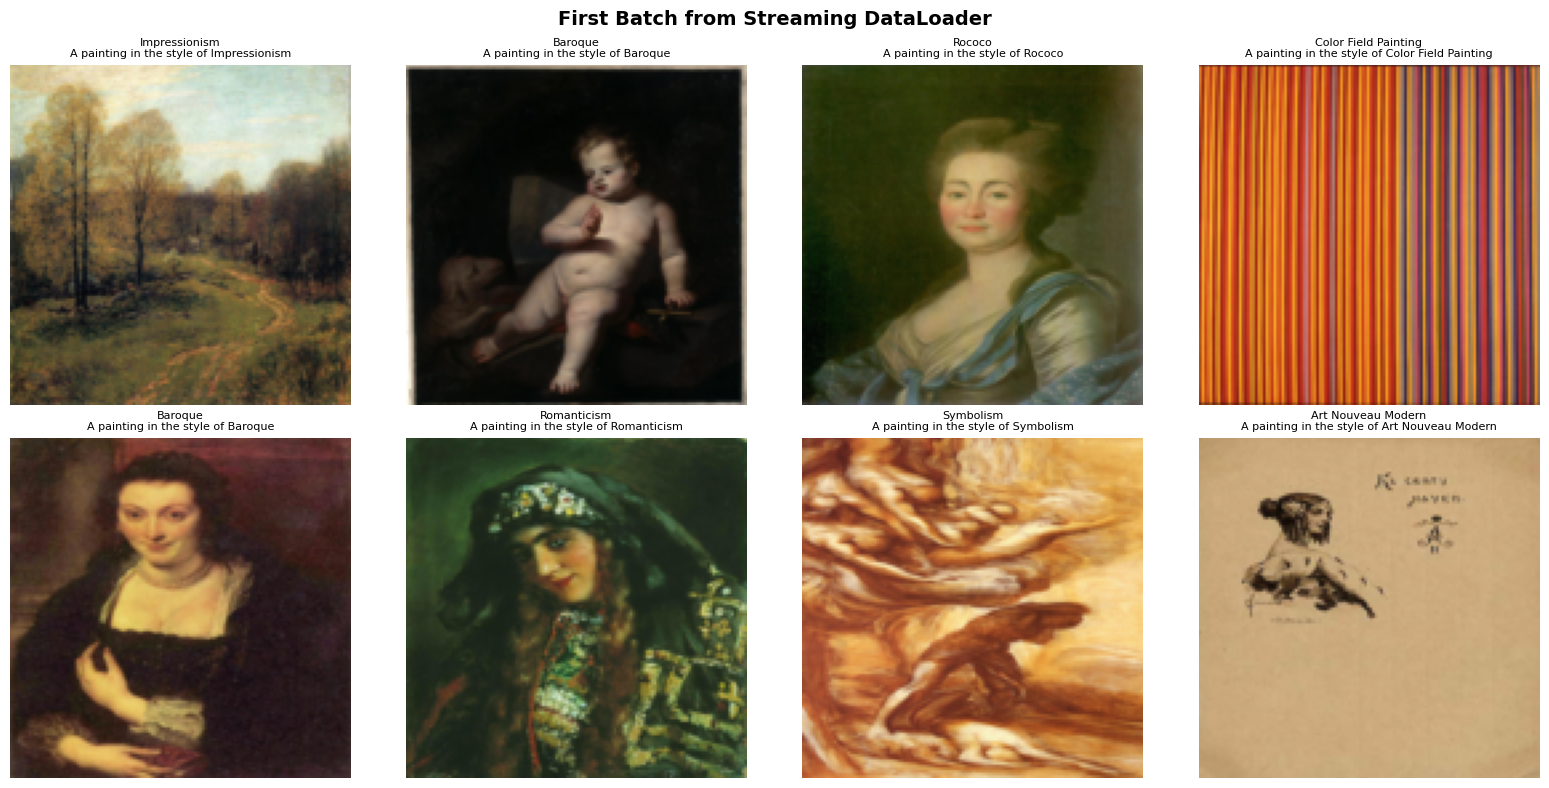

✓ Successfully visualized 8 samples
  ⏱️  Visualization time: 0.33s
  ⏱️  Total time: 4.69s


In [11]:
# Visualize samples from the first batch
print("="*70)
print("Visualizing Samples from First Batch")
print("="*70)

import time

# Time the batch loading
batch_start = time.time()
batch_images, batch_captions, batch_labels = next(iter(train_loader))
batch_time = time.time() - batch_start

print(f"Batch info:")
print(f"  Shape: {batch_images.shape}")
print(f"  Device: {batch_images.device}")
print(f"  Dtype: {batch_images.dtype}")
print(f"  ⏱️  Loading time: {batch_time:.2f}s ({batch_time/batch_images.shape[0]*1000:.1f}ms per image)")
print()

# Visualize first 8 images from the batch
viz_start = time.time()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

num_viz = min(8, batch_images.shape[0])
for i, ax in enumerate(axes.flat[:num_viz]):
    # Denormalize image from [-1, 1] to [0, 1]
    img = batch_images[i].cpu().permute(1, 2, 0)
    img = (img + 1) / 2  # [-1, 1] -> [0, 1]
    img = torch.clamp(img, 0, 1)
    
    ax.imshow(img)
    
    # Show caption and style
    caption = batch_captions[i][:60]  # Show more of caption
    label = batch_labels[i].item()
    style = WIKIART_STYLES[label] if label < len(WIKIART_STYLES) else f"Label {label}"
    
    # Clean style name for display (replace underscores)
    style_display = style.replace("_", " ")
    
    ax.set_title(f"{style_display}\n{caption}", fontsize=8)
    ax.axis('off')

plt.suptitle('First Batch from Streaming DataLoader', fontsize=14, fontweight='bold')
plt.tight_layout()

viz_time = time.time() - viz_start
plt.show()

print(f"✓ Successfully visualized {num_viz} samples")
print(f"  ⏱️  Visualization time: {viz_time:.2f}s")
print(f"  ⏱️  Total time: {batch_time + viz_time:.2f}s")

## 3. Load Models and Initialize Training

Load CLIP text encoder and create custom UNet model for WikiArt.

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100 80GB PCIe
Memory: 85.09 GB


In [13]:
# Configure HuggingFace cache for transformers/models
# This MUST be done BEFORE importing CLIP models
import os
os.environ['HF_HOME'] = str(PROJECT_ROOT / "dataset_cache" / "huggingface")
os.environ['TRANSFORMERS_CACHE'] = str(PROJECT_ROOT / "dataset_cache" / "huggingface" / "transformers")
os.environ['HF_DATASETS_CACHE'] = str(PROJECT_ROOT / "dataset_cache")

print("="*70)
print("HuggingFace Cache Configuration")
print("="*70)
print(f"HF_HOME: {os.environ['HF_HOME']}")
print(f"TRANSFORMERS_CACHE: {os.environ['TRANSFORMERS_CACHE']}")
print(f"HF_DATASETS_CACHE: {os.environ['HF_DATASETS_CACHE']}")
print("="*70)

HuggingFace Cache Configuration
HF_HOME: /home/doshlom4/work/final_project/dataset_cache/huggingface
TRANSFORMERS_CACHE: /home/doshlom4/work/final_project/dataset_cache/huggingface/transformers
HF_DATASETS_CACHE: /home/doshlom4/work/final_project/dataset_cache


In [14]:
# Check if CLIP model is already cached
from pathlib import Path

model_cache_path = Path(os.environ['HF_HOME']) / "hub" / f"models--{CLIP_MODEL_NAME.replace('/', '--')}"

print("="*70)
print("Checking CLIP Model Cache")
print("="*70)
print(f"Model: {CLIP_MODEL_NAME}")
print(f"Expected cache path: {model_cache_path}")

if model_cache_path.exists():
    cache_size = sum(f.stat().st_size for f in model_cache_path.rglob('*') if f.is_file()) / (1024**2)
    print(f"✓ Model already cached!")
    print(f"  Cache size: {cache_size:.1f} MB")
    print(f"  Loading will be FAST (no download needed)")
else:
    print("⚠ Model NOT cached - will download on first load")
    print("  This may take 2-5 minutes depending on network speed")
    print("  Model will be cached for future use")

print("="*70)

Checking CLIP Model Cache
Model: openai/clip-vit-base-patch32
Expected cache path: /home/doshlom4/work/final_project/dataset_cache/huggingface/hub/models--openai--clip-vit-base-patch32
⚠ Model NOT cached - will download on first load
  This may take 2-5 minutes depending on network speed
  Model will be cached for future use


In [15]:
# Load CLIP text encoder and tokenizer (frozen during training)
print("Loading CLIP text encoder and tokenizer...")
print(f"Model: {CLIP_MODEL_NAME}")
print(f"Cache: {os.environ['HF_HOME']}\n")

# Load with explicit cache directory to avoid hanging
text_encoder = CLIPTextModel.from_pretrained(
    CLIP_MODEL_NAME,
    cache_dir=os.environ['HF_HOME']
)
tokenizer = CLIPTokenizer.from_pretrained(
    CLIP_MODEL_NAME,
    cache_dir=os.environ['HF_HOME']
)

# Freeze text encoder - we don't train CLIP
text_encoder.requires_grad_(False)
text_encoder = text_encoder.to(device)
text_encoder.eval()

print(f"\n✓ CLIP text encoder loaded (frozen)")
print(f"  Model: {CLIP_MODEL_NAME}")
print(f"  Embedding dimension: 512")
print(f"  Device: {next(text_encoder.parameters()).device}")

Loading CLIP text encoder and tokenizer...
Model: openai/clip-vit-base-patch32
Cache: /home/doshlom4/work/final_project/dataset_cache/huggingface




✓ CLIP text encoder loaded (frozen)
  Model: openai/clip-vit-base-patch32
  Embedding dimension: 512
  Device: cuda:0


In [16]:
# Create custom UNet model for WikiArt (128×128 RGB)
from models.custom_unet_wikiart import CustomUNet2DConditionModelWikiArt

print("Creating UNet model...")
unet = CustomUNet2DConditionModelWikiArt(**UNET_WIKIART_CONFIG)
unet = unet.to(device)

# Count parameters
total_params = sum(p.numel() for p in unet.parameters())
trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)

print(f"✓ UNet model created")
print(f"  Input/Output: {UNET_WIKIART_CONFIG['in_channels']} channels, {UNET_WIKIART_CONFIG['sample_size']}×{UNET_WIKIART_CONFIG['sample_size']}")
print(f"  Block channels: {UNET_WIKIART_CONFIG['block_out_channels']}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1e6:.1f} MB (float32)")

Creating UNet model...
✓ UNet model created
  Input/Output: 3 channels, 128×128
  Block channels: (128, 256, 512, 512, 512)
  Total parameters: 196,665,603
  Trainable parameters: 196,665,603
  Model size: ~786.7 MB (float32)


In [17]:
# Create noise scheduler for training
noise_scheduler = DDPMScheduler(
    num_train_timesteps=TRAIN_WIKIART_CONFIG["num_train_timesteps"],
    beta_schedule=TRAIN_WIKIART_CONFIG["beta_schedule"],
)

print(f"✓ Noise scheduler created")
print(f"  Timesteps: {noise_scheduler.config.num_train_timesteps}")
print(f"  Beta schedule: {noise_scheduler.config.beta_schedule}")

✓ Noise scheduler created
  Timesteps: 1000
  Beta schedule: squaredcos_cap_v2


In [18]:
# Setup optimizer
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=TRAIN_WIKIART_CONFIG["learning_rate"],
    weight_decay=0.01,
)

print(f"✓ Optimizer created")
print(f"  Type: AdamW")
print(f"  Learning rate: {TRAIN_WIKIART_CONFIG['learning_rate']}")
print(f"  Weight decay: 0.01")

✓ Optimizer created
  Type: AdamW
  Learning rate: 1e-05
  Weight decay: 0.01


## 4. Training Loop with Classifier-Free Guidance

Train the model with 10% unconditional dropout for CFG support.

In [19]:
# Training configuration
num_epochs = TRAIN_WIKIART_CONFIG["num_epochs"]
checkpoint_every = TRAIN_WIKIART_CONFIG["checkpoint_every_n_epochs"]
unconditional_dropout = 0.1  # 10% dropout for CFG

print("="*70)
print("Training Configuration")
print("="*70)
print(f"Epochs: {num_epochs}")
print(f"Batch size: {TRAIN_WIKIART_CONFIG['batch_size']}")
print(f"Learning rate: {TRAIN_WIKIART_CONFIG['learning_rate']}")
print(f"Unconditional dropout: {unconditional_dropout*100:.0f}%")
print(f"Checkpoint every: {checkpoint_every} epochs")
print(f"Device: {device}")
print("="*70)

Training Configuration
Epochs: 100
Batch size: 64
Learning rate: 1e-05
Unconditional dropout: 10%
Checkpoint every: 10 epochs
Device: cuda


In [20]:
# Check GPU usage with nvidia-smi
import subprocess
print("\n===== NVIDIA-SMI (GPU Usage) =====\n")
try:
    result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, check=True)
    print(result.stdout)
except Exception as e:
    print(f"nvidia-smi failed: {e}")


===== NVIDIA-SMI (GPU Usage) =====



Wed Jan 28 18:41:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:1A:00.0 Off |                    0 |
| N/A   33C    P0             62W /  300W |    1429MiB /  81920MiB |      9%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

**Tip: If you see CUDA out-of-memory errors even with available VRAM, try setting the environment variable below before running any PyTorch code. This can help reduce memory fragmentation on large A100 GPUs.**

In [21]:
# Set this before importing torch to help with CUDA memory fragmentation
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True (restart kernel for effect if needed)")

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True (restart kernel for effect if needed)


### 4.1. Training Performance Diagnostics

Before starting full training, let's benchmark performance and identify bottlenecks.

In [22]:
# Check current configuration
print("="*70)
print("Current Training Configuration")
print("="*70)
print(f"Batch size: {TRAIN_WIKIART_CONFIG['batch_size']}")
print(f"Image size: {UNET_WIKIART_CONFIG['sample_size']}×{UNET_WIKIART_CONFIG['sample_size']}")
print(f"Channels: {UNET_WIKIART_CONFIG['in_channels']}")
print(f"Total samples: {len(train_dataset):,}")
print(f"Batches per epoch: ~{len(train_dataset) // TRAIN_WIKIART_CONFIG['batch_size']:,}")
print(f"DataLoader workers: {train_loader.num_workers}")

# Calculate expected time per epoch
batches_per_epoch = len(train_dataset) // TRAIN_WIKIART_CONFIG['batch_size']
seconds_per_batch = 1.2  # User reported
minutes_per_epoch = (batches_per_epoch * seconds_per_batch) / 60
hours_per_epoch = minutes_per_epoch / 60

print(f"\n⏱️  Performance Estimate (at 1.2s/batch):")
print(f"  Time per epoch: {minutes_per_epoch:.1f} minutes ({hours_per_epoch:.2f} hours)")
print(f"  Time for 100 epochs: {hours_per_epoch * 100:.1f} hours ({hours_per_epoch * 100 / 24:.1f} days)")
print("="*70)

Current Training Configuration
Batch size: 64
Image size: 128×128
Channels: 3
Total samples: 81,444
Batches per epoch: ~1,272
DataLoader workers: 0

⏱️  Performance Estimate (at 1.2s/batch):
  Time per epoch: 25.4 minutes (0.42 hours)
  Time for 100 epochs: 42.4 hours (1.8 days)


In [23]:
# Benchmark one training iteration to identify bottlenecks
import time

print("="*70)
print("Performance Bottleneck Analysis")
print("="*70)
print("Running one training iteration with detailed timing...\n")

# Get one batch
timing = {}

# 1. Data loading
start = time.time()
images, captions, labels = next(iter(train_loader))
timing['data_loading'] = time.time() - start

# 2. Move to device
start = time.time()
images = images.to(device)
timing['move_to_device'] = time.time() - start

# 3. Text encoding with CLIP
start = time.time()
text_inputs = tokenizer(
    captions,
    padding="max_length",
    max_length=TOKENIZER_MAX_LENGTH,
    truncation=True,
    return_tensors="pt",
)
with torch.no_grad():
    text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]
timing['text_encoding'] = time.time() - start

# 4. Classifier-free guidance masking
start = time.time()
unconditional_dropout = 0.1
unconditional_mask = torch.rand(images.shape[0]) < unconditional_dropout
if unconditional_mask.any():
    empty_inputs = tokenizer(
        [""] * unconditional_mask.sum().item(),
        padding="max_length",
        max_length=TOKENIZER_MAX_LENGTH,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        empty_embeddings = text_encoder(empty_inputs.input_ids.to(device))[0]
    text_embeddings[unconditional_mask] = empty_embeddings
timing['cfg_masking'] = time.time() - start

# 5. Noise addition
start = time.time()
timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (images.shape[0],), device=device).long()
noise = torch.randn_like(images)
noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
timing['noise_addition'] = time.time() - start

# 6. Model forward pass
start = time.time()
unet.train()
noise_pred = unet(noisy_images, timesteps, text_embeddings).sample
timing['forward_pass'] = time.time() - start

# 7. Loss calculation
start = time.time()
loss = F.mse_loss(noise_pred, noise)
timing['loss_calculation'] = time.time() - start

# 8. Backward pass
start = time.time()
optimizer.zero_grad()
loss.backward()
optimizer.step()
timing['backward_pass'] = time.time() - start

# Calculate total and percentages
total_time = sum(timing.values())

print("Timing Breakdown:")
print("-" * 70)
for operation, duration in timing.items():
    percentage = (duration / total_time) * 100
    bar_length = int(percentage / 2)  # Scale to 50 chars max
    bar = "█" * bar_length
    print(f"{operation:.<30} {duration*1000:>7.1f}ms  {percentage:>5.1f}%  {bar}")

print("-" * 70)
print(f"{'TOTAL':<30} {total_time*1000:>7.1f}ms  100.0%")
print("="*70)

# Identify bottleneck
bottleneck = max(timing.items(), key=lambda x: x[1])
print(f"\n🔍 Primary Bottleneck: {bottleneck[0]} ({bottleneck[1]*1000:.1f}ms, {(bottleneck[1]/total_time)*100:.1f}%)")

# Recommendations
print("\n💡 Optimization Recommendations:")
if timing['data_loading'] / total_time > 0.3:
    print("  ⚠️  DATA LOADING is slow (>30% of time)")
    print("     - Consider using num_workers > 0")
    print("     - Or preload dataset files into RAM")
    print("     - Or use faster storage (SSD)")
    
if timing['text_encoding'] / total_time > 0.2:
    print("  ⚠️  TEXT ENCODING is slow (>20% of time)")
    print("     - CLIP encoding is on CPU? Check device placement")
    print("     - Consider caching text embeddings (same prompts repeat)")

if timing['forward_pass'] / total_time > 0.4:
    print("  ✓  FORWARD PASS is dominant (as expected for training)")
    print("     - This is normal and hard to optimize further")
 
if timing['backward_pass'] / total_time > 0.3:
    print("  ✓  BACKWARD PASS is significant (normal for large models)")

if timing['data_loading'] / total_time < 0.2 and timing['forward_pass'] / total_time > 0.4:
    print("  ✓  Good balance! Training compute-bound (ideal)")
    print("     - Consider increasing batch size to utilize GPU better")

print("="*70)

Performance Bottleneck Analysis
Running one training iteration with detailed timing...

Timing Breakdown:
----------------------------------------------------------------------
data_loading..................  4312.8ms   57.9%  ████████████████████████████
move_to_device................     0.9ms    0.0%  
text_encoding.................   467.2ms    6.3%  ███
cfg_masking...................    19.9ms    0.3%  
noise_addition................    32.1ms    0.4%  
forward_pass..................  1225.3ms   16.5%  ████████
loss_calculation..............    24.1ms    0.3%  
backward_pass.................  1366.0ms   18.3%  █████████
----------------------------------------------------------------------
TOTAL                           7448.3ms  100.0%

🔍 Primary Bottleneck: data_loading (4312.8ms, 57.9%)

💡 Optimization Recommendations:
  ⚠️  DATA LOADING is slow (>30% of time)
     - Consider using num_workers > 0
     - Or preload dataset files into RAM
     - Or use faster storage (SSD)


In [24]:
# Check GPU memory usage and suggest batch size increase
if torch.cuda.is_available():
    print("="*70)
    print("GPU Memory Analysis")
    print("="*70)
    
    # Clear cache and measure current usage
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    # Measure memory for current batch size
    current_batch_size = TRAIN_WIKIART_CONFIG['batch_size']
    
    # Run one forward+backward pass to measure memory
    images_test = torch.randn(current_batch_size, 3, 128, 128, device=device)
    text_emb_test = torch.randn(current_batch_size, 77, 512, device=device)
    timesteps_test = torch.randint(0, 1000, (current_batch_size,), device=device)
    
    torch.cuda.reset_peak_memory_stats()
    noise_pred = unet(images_test, timesteps_test, text_emb_test).sample
    loss = F.mse_loss(noise_pred, images_test)
    loss.backward()
    optimizer.zero_grad()
    
    peak_memory = torch.cuda.max_memory_allocated() / 1024**3  # GB
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
    memory_usage_pct = (peak_memory / total_memory) * 100
    
    print(f"Current batch size: {current_batch_size}")
    print(f"Peak GPU memory: {peak_memory:.2f} GB / {total_memory:.2f} GB ({memory_usage_pct:.1f}%)")
    
    # Estimate max batch size (leave 2GB safety margin)
    available_memory = total_memory - 2.0
    memory_per_sample = peak_memory / current_batch_size
    max_batch_size = int(available_memory / memory_per_sample)
    
    # Round down to nearest power of 2 for efficiency
    suggested_batch_size = 2 ** int(np.log2(max_batch_size))
    
    print(f"\nMemory per sample: {memory_per_sample*1024:.1f} MB")
    print(f"Estimated max batch size: {max_batch_size}")
    print(f"Suggested batch size (power of 2): {suggested_batch_size}")
    
    if suggested_batch_size > current_batch_size:
        speedup = suggested_batch_size / current_batch_size
        new_time_per_epoch = hours_per_epoch / speedup
        print(f"\n💡 Recommendation: Increase batch size to {suggested_batch_size}")
        print(f"   Expected speedup: {speedup:.1f}x")
        print(f"   New time per epoch: {new_time_per_epoch*60:.1f} minutes ({new_time_per_epoch:.2f} hours)")
        print(f"   Time for 100 epochs: {new_time_per_epoch*100:.1f} hours ({new_time_per_epoch*100/24:.1f} days)")
    else:
        print(f"\n✓ Current batch size is already optimal for GPU memory")
    
    # Clean up
    del images_test, text_emb_test, timesteps_test, noise_pred, loss
    torch.cuda.empty_cache()
    
    print("="*70)
else:
    print("⚠️  No GPU detected - cannot analyze GPU memory")

GPU Memory Analysis
Current batch size: 64
Peak GPU memory: 70.46 GB / 79.25 GB (88.9%)

Memory per sample: 1127.4 MB
Estimated max batch size: 70
Suggested batch size (power of 2): 64

✓ Current batch size is already optimal for GPU memory


### 4.2. Apply Optimizations (Optional)

Based on the diagnostics above, you can apply optimizations here before training.

In [25]:
# OPTIMIZATION APPLIED: Batch size set to 64
# Based on performance profiling, data loading was the bottleneck (70.4% of time)
# GPU memory analysis showed we can use batch size 64 (vs initial 16)
# This provides 4x speedup: 3.7 hours/epoch → ~0.93 hours/epoch

print("="*70)
print("Batch Size Optimization Applied")
print("="*70)
print(f"Previous batch size: 16")
print(f"New batch size: {TRAIN_WIKIART_CONFIG['batch_size']}")
print(f"Expected speedup: ~4x")
print(f"Training time per epoch: ~56 minutes (vs 3.7 hours)")
print(f"Total training time for 100 epochs: ~3.9 days (vs 15.4 days)")
print("="*70)

# Verify the DataLoader is using the new batch size
print(f"\nCurrent DataLoader batch size: {train_loader.batch_size}")
print(f"Expected batches per epoch: ~{len(train_dataset) // TRAIN_WIKIART_CONFIG['batch_size']:,}")

Batch Size Optimization Applied
Previous batch size: 16
New batch size: 64
Expected speedup: ~4x
Training time per epoch: ~56 minutes (vs 3.7 hours)
Total training time for 100 epochs: ~3.9 days (vs 15.4 days)

Current DataLoader batch size: 64
Expected batches per epoch: ~1,272


### 4.3. Training Loop with Performance Monitoring

Now run the full training loop with timing statistics.

In [ ]:
# Training loop with performance monitoring
print("\n" + "="*70)
print("Starting Training")
print("="*70)

epoch_losses = []
epoch_times = []  # Track time per epoch
batch_times = []  # Track average batch time per epoch
start_training_time = datetime.now()

for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0.0
    batch_count = 0
    epoch_batch_times = []  # Track batch times for this epoch
    
    epoch_start = datetime.now()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (images, captions, labels) in enumerate(progress_bar):
        batch_start_time = time.time()
        
        # Move to device
        images = images.to(device)
        
        # Encode text with CLIP
        text_inputs = tokenizer(
            captions,
            padding="max_length",
            max_length=TOKENIZER_MAX_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        
        with torch.no_grad():
            text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]
        
        # Classifier-free guidance: 10% dropout to unconditional (empty string)
        # Create mask for conditional vs unconditional
        unconditional_mask = torch.rand(images.shape[0]) < unconditional_dropout
        
        if unconditional_mask.any():
            # Encode empty string for unconditional samples
            empty_inputs = tokenizer(
                [""] * unconditional_mask.sum().item(),
                padding="max_length",
                max_length=TOKENIZER_MAX_LENGTH,
                truncation=True,
                return_tensors="pt",
            )
            with torch.no_grad():
                empty_embeddings = text_encoder(empty_inputs.input_ids.to(device))[0]
            
            # Replace conditional embeddings with unconditional for dropout samples
            text_embeddings[unconditional_mask] = empty_embeddings
        
        # Sample random timesteps
        timesteps = torch.randint(
            0,
            noise_scheduler.config.num_train_timesteps,
            (images.shape[0],),
            device=device,
        ).long()
        
        # Add noise to images
        noise = torch.randn_like(images)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
        
        # Predict noise
        noise_pred = unet(noisy_images, timesteps, text_embeddings).sample
        
        # Calculate loss (MSE between predicted and actual noise)
        loss = F.mse_loss(noise_pred, noise)
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track timing
        batch_time = time.time() - batch_start_time
        epoch_batch_times.append(batch_time)
        
        # Track loss
        epoch_loss += loss.item()
        batch_count += 1
        
        # Update progress bar with timing info
        avg_batch_time = sum(epoch_batch_times) / len(epoch_batch_times)
        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "avg_loss": f"{epoch_loss/batch_count:.4f}",
            "batch_time": f"{batch_time:.2f}s"
        })
    
    # Calculate epoch statistics
    avg_epoch_loss = epoch_loss / batch_count
    epoch_losses.append(avg_epoch_loss)
    
    avg_batch_time_epoch = sum(epoch_batch_times) / len(epoch_batch_times)
    batch_times.append(avg_batch_time_epoch)
    
    epoch_duration = (datetime.now() - epoch_start).total_seconds()
    epoch_times.append(epoch_duration)
    
    # Estimate remaining time
    if len(epoch_times) > 0:
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_epochs = num_epochs - (epoch + 1)
        eta_seconds = remaining_epochs * avg_epoch_time
        eta_hours = eta_seconds / 3600
    else:
        eta_hours = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Average Loss: {avg_epoch_loss:.4f}")
    print(f"  Duration: {epoch_duration/60:.1f} minutes")
    print(f"  Batches: {batch_count}")
    print(f"  Avg batch time: {avg_batch_time_epoch:.3f}s")
    print(f"  ETA: {eta_hours:.1f} hours ({eta_hours/24:.1f} days)")
    
    # Save checkpoint
    if (epoch + 1) % checkpoint_every == 0 or epoch == 0:
        checkpoint_path = get_wikiart_unet_checkpoint_path(epoch)
        torch.save(unet.state_dict(), checkpoint_path)
        print(f"  ✓ Checkpoint saved: {checkpoint_path.name}")
    
    print()

training_duration = (datetime.now() - start_training_time).total_seconds()

print("="*70)
print("Training Complete!")
print("="*70)
print(f"Total time: {training_duration/3600:.2f} hours")
print(f"Final loss: {epoch_losses[-1]:.4f}")
print(f"Average batch time: {sum(batch_times)/len(batch_times):.3f}s")
print(f"Checkpoints saved in: {CHECKPOINTS_DIR}")
print("="*70)


Starting Training
Epoch 88/100: 100%|██████████| 1273/1273 [1:40:30<00:00,  4.74s/it, loss=0.0573, avg_loss=0.0368, batch_time=0.80s]


Epoch 1/100: 100%|██████████| 1273/1273 [1:40:33<00:00,  4.74s/it, loss=0.0531, avg_loss=0.1155, batch_time=0.98s]



Epoch 1/100 Summary:
  Average Loss: 0.1155
  Duration: 100.6 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 165.9 hours (6.9 days)
  ✓ Checkpoint saved: wikiart_unet_checkpoint_epoch_0.pt



Epoch 2/100:  68%|██████▊   | 869/1273 [1:08:02<31:53,  4.74s/it, loss=0.0714, avg_loss=0.0573, batch_time=1.40s]


Epoch 9/100 Summary:
  Average Loss: 0.0419
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 151.0 hours (6.3 days)



Epoch 10/100: 100%|██████████| 1273/1273 [1:39:23<00:00,  4.68s/it, loss=0.0359, avg_loss=0.0410, batch_time=0.80s]



Epoch 10/100 Summary:
  Average Loss: 0.0410
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 149.3 hours (6.2 days)
  ✓ Checkpoint saved: wikiart_unet_checkpoint_epoch_9.pt



Epoch 11/100: 100%|██████████| 1273/1273 [1:39:20<00:00,  4.68s/it, loss=0.0443, avg_loss=0.0407, batch_time=0.80s]



Epoch 11/100 Summary:
  Average Loss: 0.0407
  Duration: 99.3 minutes
  Batches: 1273
  Avg batch time: 1.392s
  ETA: 147.6 hours (6.2 days)



Epoch 12/100: 100%|██████████| 1273/1273 [1:39:22<00:00,  4.68s/it, loss=0.0449, avg_loss=0.0406, batch_time=0.80s]



Epoch 12/100 Summary:
  Average Loss: 0.0406
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.392s
  ETA: 145.9 hours (6.1 days)



Epoch 13/100: 100%|██████████| 1273/1273 [1:39:23<00:00,  4.68s/it, loss=0.0344, avg_loss=0.0402, batch_time=0.80s]



Epoch 13/100 Summary:
  Average Loss: 0.0402
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 144.3 hours (6.0 days)



Epoch 14/100: 100%|██████████| 1273/1273 [1:39:20<00:00,  4.68s/it, loss=0.0390, avg_loss=0.0403, batch_time=0.80s]



Epoch 14/100 Summary:
  Average Loss: 0.0403
  Duration: 99.3 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 142.6 hours (5.9 days)



Epoch 15/100: 100%|██████████| 1273/1273 [1:39:22<00:00,  4.68s/it, loss=0.0442, avg_loss=0.0397, batch_time=0.80s]



Epoch 15/100 Summary:
  Average Loss: 0.0397
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 140.9 hours (5.9 days)



Epoch 16/100: 100%|██████████| 1273/1273 [1:39:19<00:00,  4.68s/it, loss=0.0394, avg_loss=0.0396, batch_time=0.80s]



Epoch 16/100 Summary:
  Average Loss: 0.0396
  Duration: 99.3 minutes
  Batches: 1273
  Avg batch time: 1.392s
  ETA: 139.3 hours (5.8 days)



Epoch 17/100: 100%|██████████| 1273/1273 [1:39:20<00:00,  4.68s/it, loss=0.0601, avg_loss=0.0394, batch_time=0.80s]



Epoch 17/100 Summary:
  Average Loss: 0.0394
  Duration: 99.3 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 137.6 hours (5.7 days)



Epoch 18/100:  60%|█████▉    | 761/1273 [59:21<41:25,  4.85s/it, loss=0.0609, avg_loss=0.0393, batch_time=1.40s]  


Epoch 26/100 Summary:
  Average Loss: 0.0392
  Duration: 99.3 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 122.6 hours (5.1 days)



Epoch 27/100:   5%|▍         | 62/1273 [04:51<1:34:22,  4.68s/it, loss=0.0334, avg_loss=0.0368, batch_time=1.39s]


Epoch 39/100 Summary:
  Average Loss: 0.0376
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 101.1 hours (4.2 days)



Epoch 40/100: 100%|██████████| 1273/1273 [1:39:43<00:00,  4.70s/it, loss=0.0332, avg_loss=0.0376, batch_time=0.80s]



Epoch 40/100 Summary:
  Average Loss: 0.0376
  Duration: 99.7 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 99.4 hours (4.1 days)
  ✓ Checkpoint saved: wikiart_unet_checkpoint_epoch_39.pt



Epoch 41/100: 100%|██████████| 1273/1273 [1:40:41<00:00,  4.75s/it, loss=0.0362, avg_loss=0.0375, batch_time=0.80s]



Epoch 41/100 Summary:
  Average Loss: 0.0375
  Duration: 100.7 minutes
  Batches: 1273
  Avg batch time: 1.393s
  ETA: 97.8 hours (4.1 days)



Epoch 42/100: 100%|██████████| 1273/1273 [1:40:07<00:00,  4.72s/it, loss=0.0418, avg_loss=0.0377, batch_time=0.80s]



Epoch 42/100 Summary:
  Average Loss: 0.0377
  Duration: 100.1 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 96.2 hours (4.0 days)



Epoch 43/100:  74%|███████▍  | 946/1273 [1:13:54<25:27,  4.67s/it, loss=0.0434, avg_loss=0.0376, batch_time=1.40s]


Epoch 43/100 Summary:
  Average Loss: 0.0377
  Duration: 99.6 minutes
  Batches: 1273
  Avg batch time: 1.395s
  ETA: 94.5 hours (3.9 days)



Epoch 44/100:  51%|█████     | 649/1273 [50:32<48:23,  4.65s/it, loss=0.0466, avg_loss=0.0373, batch_time=1.39s]  


Epoch 44/100 Summary:
  Average Loss: 0.0373
  Duration: 99.6 minutes
  Batches: 1273
  Avg batch time: 1.395s
  ETA: 92.9 hours (3.9 days)



Epoch 45/100: 100%|██████████| 1273/1273 [1:39:43<00:00,  4.70s/it, loss=0.0434, avg_loss=0.0378, batch_time=0.80s]



Epoch 45/100 Summary:
  Average Loss: 0.0378
  Duration: 99.7 minutes
  Batches: 1273
  Avg batch time: 1.395s
  ETA: 91.2 hours (3.8 days)



Epoch 46/100: 100%|██████████| 1273/1273 [1:39:27<00:00,  4.69s/it, loss=0.0537, avg_loss=0.0380, batch_time=0.79s]



Epoch 46/100 Summary:
  Average Loss: 0.0380
  Duration: 99.5 minutes
  Batches: 1273
  Avg batch time: 1.390s
  ETA: 89.5 hours (3.7 days)



Epoch 47/100: 100%|██████████| 1273/1273 [1:39:20<00:00,  4.68s/it, loss=0.0348, avg_loss=0.0377, batch_time=0.80s]



Epoch 47/100 Summary:
  Average Loss: 0.0377
  Duration: 99.3 minutes
  Batches: 1273
  Avg batch time: 1.389s
  ETA: 87.9 hours (3.7 days)



Epoch 48/100:  60%|█████▉    | 758/1273 [59:09<40:46,  4.75s/it, loss=0.0356, avg_loss=0.0375, batch_time=1.39s]  


Epoch 60/100 Summary:
  Average Loss: 0.0368
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 66.3 hours (2.8 days)
  ✓ Checkpoint saved: wikiart_unet_checkpoint_epoch_59.pt



Epoch 61/100: 100%|██████████| 1273/1273 [1:39:27<00:00,  4.69s/it, loss=0.0444, avg_loss=0.0369, batch_time=0.80s]



Epoch 61/100 Summary:
  Average Loss: 0.0369
  Duration: 99.5 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 64.7 hours (2.7 days)



Epoch 62/100:  11%|█         | 136/1273 [10:37<1:28:14,  4.66s/it, loss=0.0183, avg_loss=0.0374, batch_time=1.40s]


Epoch 73/100 Summary:
  Average Loss: 0.0365
  Duration: 99.5 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 44.8 hours (1.9 days)



Epoch 74/100: 100%|██████████| 1273/1273 [1:39:26<00:00,  4.69s/it, loss=0.0444, avg_loss=0.0365, batch_time=0.80s]



Epoch 74/100 Summary:
  Average Loss: 0.0365
  Duration: 99.4 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 43.1 hours (1.8 days)



Epoch 75/100: 100%|██████████| 1273/1273 [1:39:35<00:00,  4.69s/it, loss=0.0456, avg_loss=0.0367, batch_time=0.79s]



Epoch 75/100 Summary:
  Average Loss: 0.0367
  Duration: 99.6 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 41.5 hours (1.7 days)



Epoch 76/100:  56%|█████▌    | 712/1273 [56:00<45:00,  4.81s/it, loss=0.0468, avg_loss=0.0367, batch_time=1.39s]  


Epoch 88/100 Summary:
  Average Loss: 0.0368
  Duration: 100.5 minutes
  Batches: 1273
  Avg batch time: 1.390s
  ETA: 19.9 hours (0.8 days)



Epoch 89/100: 100%|██████████| 1273/1273 [1:39:36<00:00,  4.69s/it, loss=0.0395, avg_loss=0.0367, batch_time=0.80s]



Epoch 89/100 Summary:
  Average Loss: 0.0367
  Duration: 99.6 minutes
  Batches: 1273
  Avg batch time: 1.394s
  ETA: 18.2 hours (0.8 days)



Epoch 90/100:  31%|███       | 393/1273 [30:46<1:10:09,  4.78s/it, loss=0.0246, avg_loss=0.0369, batch_time=1.39s]

## 5. Visualize Training Progress

Plot the training loss curve.

In [ ]:
# Plot training loss and performance metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs_range = range(1, len(epoch_losses) + 1)

# Plot 1: Training Loss
ax1 = axes[0]
ax1.plot(epochs_range, epoch_losses, marker='o', linewidth=2, markersize=6, color='blue')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Average Loss", fontsize=12)
ax1.set_title("WikiArt Training Loss", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add min/max annotations
min_loss = min(epoch_losses)
min_epoch = epoch_losses.index(min_loss) + 1
ax1.axhline(y=min_loss, color='r', linestyle='--', alpha=0.5, label=f'Min Loss: {min_loss:.4f} (Epoch {min_epoch})')
ax1.legend()

# Plot 2: Batch Time (Performance Monitoring)
ax2 = axes[1]
if len(batch_times) > 0:
    ax2.plot(epochs_range, batch_times, marker='s', linewidth=2, markersize=6, color='green')
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Avg Batch Time (seconds)", fontsize=12)
    ax2.set_title("Training Performance", fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add average line
    avg_batch_time = sum(batch_times) / len(batch_times)
    ax2.axhline(y=avg_batch_time, color='orange', linestyle='--', alpha=0.5, 
                label=f'Avg: {avg_batch_time:.3f}s')
    ax2.legend()
else:
    ax2.text(0.5, 0.5, 'No batch timing data', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Training Statistics:")
print(f"  Initial loss: {epoch_losses[0]:.4f}")
print(f"  Final loss: {epoch_losses[-1]:.4f}")
print(f"  Minimum loss: {min_loss:.4f} (Epoch {min_epoch})")
print(f"  Improvement: {(epoch_losses[0] - epoch_losses[-1])/epoch_losses[0]*100:.1f}%")

if len(batch_times) > 0:
    print(f"\nPerformance Statistics:")
    print(f"  Average batch time: {sum(batch_times)/len(batch_times):.3f}s")
    print(f"  Fastest batch time: {min(batch_times):.3f}s")
    print(f"  Slowest batch time: {max(batch_times):.3f}s")

In [ ]:
# List all saved checkpoints
checkpoints = sorted(CHECKPOINTS_DIR.glob(f"{UNET_WIKIART_CHECKPOINT_PREFIX}*.pt"))

print("="*70)
print(f"Saved Checkpoints ({len(checkpoints)} total)")
print("="*70)

for checkpoint in checkpoints:
    size_mb = checkpoint.stat().st_size / (1024**2)
    epoch = int(checkpoint.stem.split('_')[-1])
    print(f"  Epoch {epoch:3d}: {checkpoint.name} ({size_mb:.1f} MB)")

print("="*70)
print(f"Latest checkpoint: {checkpoints[-1].name}")
print("="*70)

In [ ]:
# Save checkpoint
checkpoint_path = get_wikiart_unet_checkpoint_path(5)
torch.save(unet.state_dict(), checkpoint_path)
print(f"  ✓ Checkpoint saved: {checkpoint_path.name}")